# SSH Free Run

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float

from jaxsw._src.operators.functional import advection as F_adv
from jaxsw._src.operators.functional import geostrophic as F_geos
from jaxsw._src.operators.functional import cgrid as F_cgrid
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.boundaries.helmholtz import enforce_boundaries_helmholtz

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

In this problem, we are looking at sea surface height (SSH) in relation to the Quasi-Geostrophic (QG) equations. These equations are a simplified form for the Navier-Stokes equations with approximations like *hydrostatic approximation*, *small aspect ratio*, and a *small Rossby number*. Ideally, these equations might be a decent approximation at mesoscale (100km - 10,000km). In this application, we will see how SSH propagates with the QG equations.

## Equations


This is a very simplified equation but

$$
\begin{aligned}
\partial_t q &= - \det\boldsymbol{J}(\psi,q) - \beta\partial_x\psi \\
\psi &= \frac{g}{f_0}\eta \\
q &= \nabla^2 \psi - \frac{f_0^2}{c_1^2}\psi \\
\psi &= \frac{f_0}{g}\eta \\
u &= -\partial_y\psi \\
v &= \partial_x\psi \\
f &= 2\Omega\sin\theta_0 + \frac{1}{R}2\Omega\cos\theta_0 y \\
f_0 &= \mathcal{E}[f] \\
L_R &= \frac{c_1}{f_0}
\end{aligned}
$$

where:
* $\theta_0$ is the mean latitude
* $f_0=2\Omega\sin\theta_0$ is the Coriolis parameter at mean latitude
* $\beta=\frac{1}{R}2\Omega\cos\theta_0$ is the $\beta$-plane approximation at mean latitude
* $L_R$ is the Rossby deformation radius
* $\Omega$ is the angular frequency of rotation
* $R$ is the radius of the Earth

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

## Read input SSH

In [2]:
file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
file = "/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"


# ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60_GULFSTREAM_degraded.nc')
# ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc', decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
# ds = xr.open_dataset("/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.decoded.nc")
ds = xr.open_dataset(
    file,
    decode_times=False,
).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
# ds = ds.coarsen(lon=3,lat=3).mean()
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 ...

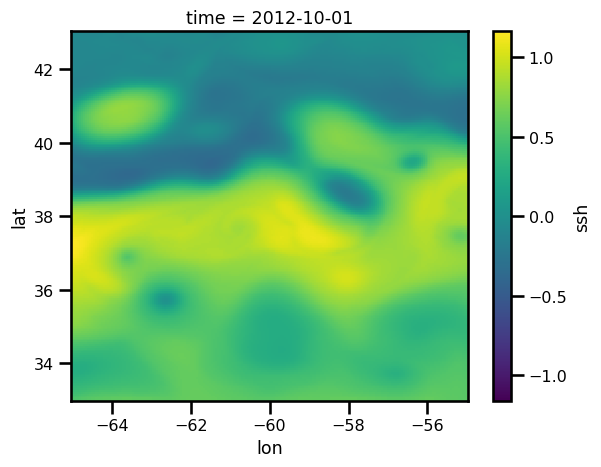

In [3]:
ds.ssh.isel(time=0).plot.pcolormesh(cmap="viridis")

## Strategy

This is a slightly different problem than some of the previous problems.

**Lat/Lon Domain**. Our domain is in 

**SSH**. In this case, we have sea surface height "observations" but they are not actually used within the QG equations. So we need to do a transformation into the QG domain which is in terms of the stream function, $\psi$, and the potential vorticity, $q$.

## Domain

Already, we have to do something slightly different than the previous tutorials. 
We are dealing with latitude/longitude so we need to do a coordinate transformation to x,y space, i.e. a local tangent plane.
I have a specialized tutorial about how we do this in practice which can be found [here]() (**TODO**).


In [4]:
from jaxsw._src.domain.latlon import LatLonMeanDomain

In [5]:
lon = ds.lon.values
lat = ds.lat.values
ssh = jnp.asarray(ds.ssh[0].values.T)

domain = LatLonMeanDomain(lat=lat, lon=lon)

assert domain.size == (lon.shape[0], lat.shape[0])

domain.size, ssh.shape

((201, 201), (201, 201))

## State

So here, we need to keep track of the following state variables: 

$$
\begin{aligned}
\eta=\boldsymbol{\eta}(\vec{\mathbf{x}}) &&
\psi=\boldsymbol{\psi}(\vec{\mathbf{x}}) &&
q = \boldsymbol{q}(\vec{\mathbf{x}}) && &&
\vec{\mathbf{x}}\in\Omega,\partial\Omega
\end{aligned}
$$ (eq:qg_state)

where $\eta$ is the Sea Surface Height, $\psi$ is the stream function, and $q$ is the potential vorticity. 
All of them are along the same domain.



We also have some constants that we need to keep track of:

$$
\begin{aligned}
f_0\in\mathbb{R} &&
\beta\in\mathbb{R}
\end{aligned}
$$

where $f_0$ is the coriolis parameter and $\beta$ is the beta-plane approximation at mean latitudes.


### Initial Conditions

So these initial conditions are going to be slightly different than the previous cases: 1) we will initialize with real data and 2) we will have to "precalculate" some of the variables with the formulas listed above.
So, let's come back to this until after we define all of the functions necessary.

### Boundary Conditions

More information can be found in the tutorial...

```python
# q = enforce_boundaries_helmholtz(q, psi, beta=(f0/c1)**2)
```

### Stream Function

Here, we can directly relate the sea surface height to the stream function via this equation.

$$
\psi = \frac{g}{f}\eta
$$ 

We already have some (simple) specialized functions that can do the calculation for us.
Run the below cells to see the internal code.

In [6]:
# F_geos.ssh_to_streamfn??
# F_geos.streamfn_to_ssh??

We will do the forward and inverse transformation.
We will also check to ensure that they are invertible.

In [7]:
# forward transformation
psi = F_geos.ssh_to_streamfn(jnp.asarray(ssh), f0=domain.f0)

# inverse transform
ssh_ = F_geos.streamfn_to_ssh(psi, f0=domain.f0)

# check the inverse transformation
np.testing.assert_array_almost_equal(ssh, ssh_)

### Stream Function and Potential Vorticity

The potential vorticity is related to the stream function via the following function.

$$
q = \nabla^2\psi - \frac{f_0^2}{c_1^2}\psi
$$

We can think of this as the HelmHoltz decomposition because we have the form of 

$$
\left(\alpha\boldsymbol{\nabla} - \beta\right)
$$

#### Forward Transformation

Below we have a convenience function for calculate this transformation.
Uncomment the below code to see what it looks like under the hood.

In [8]:
# F_geos.streamfn_to_pvort??

Now, we can apply the function on the stream function to get the potential vorticity.

In [9]:
c1 = 1.5
q = F_geos.streamfn_to_pvort(
    psi, dx=domain.dx_mean, dy=domain.dx_mean, f0=domain.f0, c1=c1, accuracy=1
)

### Inverse Transformation

We are trying to solve an inversion problem of the type:

$$
\mathbf{u} = \mathbf{L}^{-1}\mathbf{b}
$$

where $\mathbf{L}=\left(\alpha\boldsymbol{\nabla} - \beta\right)$.

We will use an approximate method to solve for the potential vorticity.
We can check to see if this works using our Discrete Sine Transformation framework.

In [10]:
psi_rec = F_geos.pvort_to_streamfn(
    q,
    psi,
    dx=domain.dx_mean,
    dy=domain.dx_mean,
    f0=domain.f0,
    c1=c1,
    accuracy=1,
)

print(np.max(np.abs(psi_rec - psi)))

ssh_rec = F_geos.streamfn_to_ssh(psi_rec, f0=domain.f0)
# np.testing.assert_array_almost_equal(psi, psi_rec)

print(np.max(np.abs(ssh_rec - ssh)))

1.7462298274040222e-10
1.5543122344752192e-15


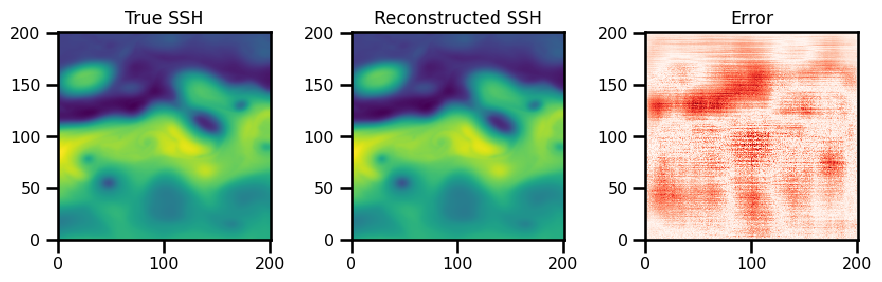

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))

ax[0].pcolormesh(ssh.T)
ax[0].set(title="True SSH")

ax[1].pcolormesh(ssh_rec.T)
ax[1].set(title="Reconstructed SSH")

ax[2].pcolormesh(np.abs(ssh_rec - ssh).T, cmap="Reds")
ax[2].set(title="Error")

plt.tight_layout()
plt.show()

## State

Seeing the above strategy, we see that we are stepping through the potential vorticity. 
So this is the variable that will make up our state.

In [12]:
import equinox as eqx


class State(eqx.Module):
    q: Array

## Parameters

In [13]:
class Params(eqx.Module):
    c1: Array = eqx.static_field()
    f0: Array = eqx.static_field()
    beta: Array = eqx.static_field()
    eta: Array
    domain: LatLonMeanDomain

### Initial State

Most of the work will go into getting into transforming the SSH into the initial state.
So we can create a few specialized functions to do so.

First, we need to extract the dataarray or dataset to get it into a LatLon Domain and a jax array.

In [14]:
def xrda_to_latlon_field(da: xr.DataArray):
    # get domain
    domain = LatLonMeanDomain(lat=da.lat.values, lon=da.lon.values)

    # transpose to get the correct dimensions
    da = da.transpose("lon", "lat")

    # get field
    return jnp.asarray(da), domain


def xrds_to_latlon_field(ds: xr.DataArray, variable: str, time: str):
    return xrda_to_latlon_field(da=ds[variable].sel(time=time))

In [15]:
# using the xr.DataArray
eta_init, domain = xrda_to_latlon_field(ds.ssh[0])

assert eta_init.shape == domain.size

# using the xr.Dataset
eta_init, domain = xrds_to_latlon_field(ds, "ssh", "2012-10-01")

assert eta_init.shape == domain.size

In [16]:
def init_state(params):
    # parse domain
    dx = dy = params.domain.dx_mean

    # parse parameters
    c1, f0, eta = params.c1, params.f0, params.eta

    # SSH -->> Stream Function
    psi = F_geos.ssh_to_streamfn(eta, f0=f0)

    # Stream Function -->> Potential Vorticity
    q = F_geos.streamfn_to_pvort(psi, dx=dx, dy=dy, f0=f0, c1=c1, accuracy=1)

    # enforce boundary conditions
    q = enforce_boundaries_helmholtz(q, psi, beta=(f0 / c1) ** 2)

    # return state module
    return State(q=q)

In [17]:
# initialize parameters
params = Params(c1=1.5, f0=domain.f0, beta=domain.beta, domain=domain, eta=eta_init)

# initialize state
state_init = init_state(params=params)

# check that we can update the state
state_new = eqx.tree_at(lambda x: x.q, state_init, state_init.q + 1)
np.testing.assert_array_equal(state_new.q, state_init.q + 1)

It's also useful to calculate the SSH from the PV. This will be useful later in the analysis

In [18]:
def ssh_from_state(state, params, axis: int = -1) -> Array:
    dx = dy = params.domain.dx_mean
    f0, c1, eta = params.f0, params.c1, params.eta
    q = state.q

    if jnp.ndim(q) > 2:
        q = q[axis]

    psi_bv = F_geos.ssh_to_streamfn(ssh=eta, f0=f0)

    psi = F_geos.pvort_to_streamfn(q, psi_bv, dx=dx, dy=dy, f0=f0, c1=c1)

    return F_geos.streamfn_to_ssh(psi, f0=domain.f0)

In [22]:
# using the xr.DataArray
eta_init, domain = xrda_to_latlon_field(ds.ssh[0])

# initialize parameters
params = Params(c1=1.5, f0=domain.f0, beta=domain.beta, domain=domain, eta=eta_init)

# initialize state
state_init = init_state(params=params)

eta_new = ssh_from_state(state_init, params)

np.testing.assert_array_almost_equal(eta_new, eta_init, decimal=9)

## Right Hand Side

We have the advection term which is the dot product between the geostrophic velocities and the gradient of the 

$$
\begin{aligned}
\begin{pmatrix}
u \\ v
\end{pmatrix} \cdot
\nabla q &= u \partial_x q + v \partial_y q
\end{aligned}
$$

if we plug in the actual $u,v$ terms, we get

$$
\begin{aligned}
\begin{pmatrix}
u \\ v
\end{pmatrix} \cdot
\nabla q &= - \partial_y\psi\partial_y q + \partial_x\psi\partial_y q \\
&= \partial_x\psi\partial_y q - \partial_y\psi\partial_y q
\end{aligned}
$$

Note, there is a famous common term that is used for a short hand notation. It's call the **determinant Jacobian** which is denoted as:

$$
\begin{aligned}
\det J(\psi, q) &= 
\frac{\partial\psi}{\partial_x}\frac{\partial q}{\partial_y} -
\frac{\partial\psi}{\partial_y}\frac{\partial q}{\partial_x} \\
&= 
\frac{\partial}{\partial_x}\left(\psi\frac{\partial q}{\partial_y}\right) -
\frac{\partial}{\partial_y}\left(\psi\frac{\partial q}{\partial_x}\right) \\
&= 
\frac{\partial}{\partial_y}\left(q\frac{\partial\psi}{\partial_x}\right) -
\frac{\partial}{\partial_x}\left(q\frac{\partial\psi}{\partial_y}\right)
\end{aligned}
$$

We can see that this is exactly equal to the above expression when we set $u=-\partial_y\psi$ and $v=\partial_x\psi$

$$
\begin{aligned}
\det J(\psi, q) &= 
v\frac{\partial q}{\partial_y} +
u \frac{\partial q}{\partial_x} \\
\end{aligned}
$$

### Upwind Scheme

This term is an advection equation. So we can use the upwind scheme to deal with this.

$$
\begin{aligned}
u\partial_x q := u^+ D_x^- q + u^- D_x^+ q \\
v\partial_y q := v^+ D_y^- q + v^- D_y^+ q \\
\end{aligned}
$$

where:
* $u^+,v^+ = u>0,v>0$
* $u^-,v^-=u<0,v<0$
* $D_x^-, D_y^-$ is a backward finite difference scheme
* $D_x^+, D_y^-$ is a forward finite difference scheme

Source: [Wikipedia](https://en.wikipedia.org/wiki/Upwind_scheme) | [Blog](https://en.wikipedia.org/wiki/Upwind_scheme)

#### Plus/Minus

$$
\begin{aligned}
\text{u-velocity}: && && u^+ &= \max(u,0) && && u^- = \min(u,0) \\
\text{v-velocity}: && && v^+ &= \max(v,0) && && v^- = \min(v,0)
\end{aligned}
$$

We have a convenience function to see how it is calculated below.
Uncomment the code in the cell below to see how it works.

In [23]:
# F_adv.advection_upwind_2D??
# F_adv.advection_upwind_1D??

In [24]:
def advection_term_upwind(q, psi, dx, dy, **kwargs) -> Array:
    # u,v schemes
    u, v = F_geos.uv_velocity(psi, dx=dx, dy=dy, accuracy=kwargs.get("accuracy", 1))

    # # Average Center Pixel
    # u = F_grid.center_average_2D(u, padding="same")
    # v = F_grid.center_average_2D(v, padding="same")

    # # Average East-West & North-South
    # u = F_grid.x_average_2D(u, padding="same")
    # v = F_grid.y_average_2D(v, padding="same")

    # print(u_avg.shape, v_avg.shape, q.shape)

    adv_term = F_adv.advection_upwind_2D(
        q, a=u, b=v, step_size=(dx, dy), way=kwargs.get("way", 1)
    )

    rhs = jnp.zeros_like(q)

    # rhs = rhs.at[1:-1, 1:-1].set(udq_dx[1:-1, 1:-1] + vdq_dy[1:-1, 1:-1])
    rhs = rhs.at[1:-1, 1:-1].set(adv_term[1:-1, 1:-1])

    return rhs


rhs = advection_term_upwind(
    q, psi, domain.dx_mean, domain.dx_mean, method="central", way=1
)

print(rhs.min(), rhs.max())

-1.3750228959774459e-07 1.3953795940515203e-07


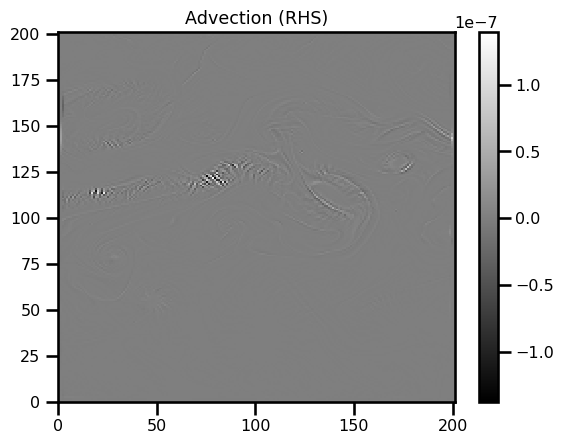

In [25]:
fig, ax = plt.subplots()

pts = ax.pcolormesh(rhs.T, cmap="gray")
ax.set(title="Advection (RHS)")
plt.colorbar(pts)

plt.show()

## Equation of Motion

Recall the PDE we want to solve.

$$
\begin{aligned}
\partial_t q &= - \det\boldsymbol{J}(\psi,q) - \beta\partial_x\psi \\
\psi &= \frac{g}{f_0}\eta
\end{aligned}
$$


Here, we outline a quick algorithm for how we can step through calculating the RHS of the PDE

$$
\begin{aligned}
\text{SSH, PV:} &&\eta^n,q^n &=  \ldots \\
\text{SF:} && \psi^n_b &= f(\eta^n) \\
\text{SF:} && \psi^{n} &= \text{LinearSolve}(q^{n}, \psi^n_b) \\
\text{RHS:} && rhs^n &= \mathbf{rhs}(\psi^n, q^n) \\
\text{PV:} && q^{n+1} &= q^{n} + \Delta t \hspace{1mm} rhs
\end{aligned}
$$

In [26]:
# from jaxsw._src.operators.functional.fd import jacobian

In [27]:
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain


class QG(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, state: State, args):
        """Quasi-Geostrophic Equations

        Equation:
            ∂q/∂t + det J(Ψ,q) = -β ∂Ψ/∂x
            q = ∇²Ψ - (f₀²/c₁²) Ψ
            Ψ = (f₀/g) η
        """
        # parse params
        params = args
        dx = dy = params.domain.dx_mean
        f0, beta, c1, eta = params.f0, params.beta, params.c1, params.eta

        # parse state
        q = state.q

        # ssh -> stream function
        psi_bv = F_geos.ssh_to_streamfn(ssh=eta, f0=f0)

        # potential vorticity -> stream function
        psi = F_geos.pvort_to_streamfn(q, psi_bv, dx=dx, dy=dy, f0=f0, c1=c1)

        # upwind scheme for advection
        q_rhs = -advection_term_upwind(q=q, psi=psi, dx=dx, dy=dy, way=1)

        # beta term
        _, v = F_geos.uv_velocity(psi, dx=dx, dy=dy)

        q_rhs += -beta * v

        # update state
        state = eqx.tree_at(lambda x: x.q, state, q_rhs)

        return state

In [28]:
# SPATIAL DISCRETIZATION
# using the xr.DataArray
eta_init, domain = xrda_to_latlon_field(ds.ssh[0])

# initialize parameters
params = Params(c1=1.5, f0=domain.f0, beta=domain.beta, domain=domain, eta=eta_init)

# initialize state
state_init = init_state(params=params)
# right hand side
state_out = QG.equation_of_motion(0, state_init, params)

In [29]:
# plot_state_2D(state_out)
# plot_state_3D(state_out)
# plot_vectorfield_2D(state_out)

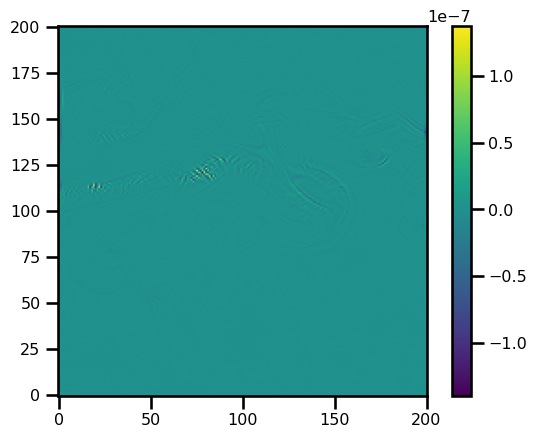

In [30]:
fig, ax = plt.subplots()

pts = ax.imshow(state_out.q.T, origin="lower")
plt.colorbar(pts)

plt.show()

## Time Stepping with Diffrax (All together)

In [31]:
dt_ = np.timedelta64(1, "h")
pd.to_timedelta(dt_).total_seconds()

3600.0

In [32]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain


num_minutes = 30
dt = pd.to_timedelta(num_minutes, unit="minutes").total_seconds()
debug = False
num_days = 5
tmin = 0.0
tmax = pd.to_timedelta(num_days, unit="days").total_seconds()

num_hours_save = 12
dt_save = pd.to_timedelta(num_hours_save, unit="hours").total_seconds()

print(f"Step Size (dt): {int(dt/60)} minutes")
print(f"Tmax: {num_days} days")
print(f"Tmax: {tmax:,} seconds | {int(tmax/60/60/24)} day(s)")

Step Size (dt): 30 minutes
Tmax: 5 days
Tmax: 432,000.0 seconds | 5 day(s)


In [33]:
# time domain
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)


t_domain

TimeDomain(tmin=0.0, tmax=432000.0, dt=1800.0)

In [34]:
num_hours_save = 6
dt_save = pd.to_timedelta(num_hours_save, unit="hours").total_seconds()

ts = jnp.arange(tmin, tmax, dt_save)
saveat = dfx.SaveAt(ts=ts)

In [35]:
# SPATIAL DISCRETIZATION
# initialize state
solver = dfx.Euler()  #
# max_steps = 10
# DYNAMICAL SYSTEM
dyn_model = QG(t_domain=t_domain, saveat=saveat, solver=solver)

In [36]:
%%time

# using the xr.DataArray
eta_init, domain = xrda_to_latlon_field(ds.ssh[0])

# initialize parameters
params = Params(c1=1.5, f0=domain.f0, beta=domain.beta, domain=domain, eta=eta_init)

# initialize state
state_init = init_state(params=params)

state_sol = dyn_model.integrate(state_init, dt, params, max_steps=10_000)

CPU times: user 4.56 s, sys: 133 ms, total: 4.69 s
Wall time: 4.63 s


In [37]:
state_sol.q.shape

(20, 201, 201)

In [38]:
ssh_t = ssh_from_state(state_sol, params)

ssh_t.min(), ssh_t.max()

(Array(-0.33095231, dtype=float64), Array(1.16310116, dtype=float64))

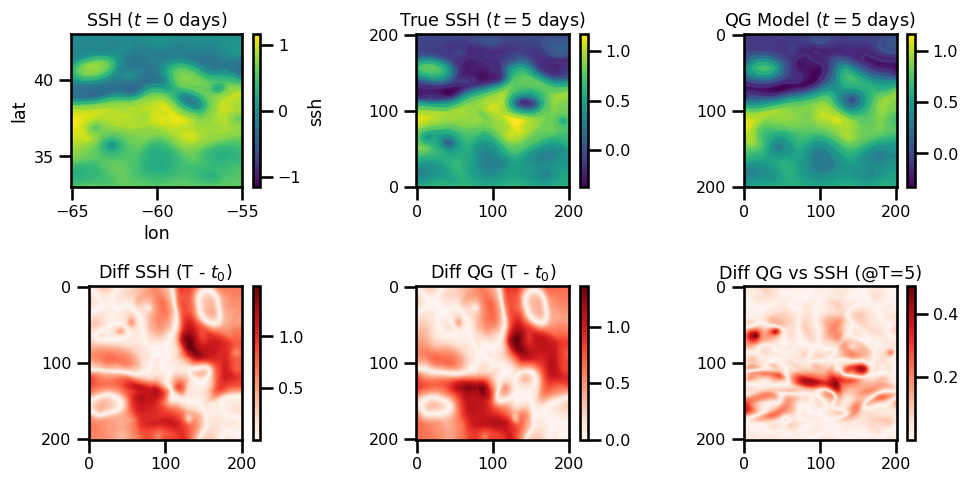

In [39]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5))

#
ds.ssh[0].plot.pcolormesh(ax=ax[0, 0], cmap="viridis")
ds.ssh[0].plot.contour(ax=ax[0, 0], cmap="viridis")

ax[0, 0].set(title=f"SSH ($t=0$ days)")
ax[0, 1].contour(ds.ssh[num_days].values, cmap="viridis")
pts = ax[0, 1].imshow(ds.ssh[num_days].values, origin="lower", cmap="viridis")
plt.colorbar(pts)
ax[0, 1].set(title=f"True SSH ($t={num_days}$ days)")

ax[0, 2].contour(np.flipud(ssh_t.T), cmap="viridis")
pts = ax[0, 2].imshow(np.flipud(ssh_t.T), cmap="viridis")
ax[0, 2].set(title=f"QG Model ($t={num_days}$ days)")
plt.colorbar(pts)


pts = ax[1, 0].imshow(np.abs(ds.ssh[0].values.T - ds.ssh[num_days].values), cmap="Reds")
plt.colorbar(pts)
ax[1, 0].set(title=f"Diff SSH (T - $t_0$)")

pts = ax[1, 1].imshow(np.abs(ds.ssh[0].values.T - ssh_t.T), cmap="Reds")
plt.colorbar(pts)
ax[1, 1].set(title=f"Diff QG (T - $t_0$)")


pts = ax[1, 2].imshow(np.abs(ds.ssh[num_days].values - ssh_t.T), cmap="Reds")
plt.colorbar(pts)
ax[1, 2].set(title=f"Diff QG vs SSH (@T={num_days})")


plt.tight_layout()
plt.show()